In [228]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim
import random

## Reading the co-integrated pair

#### The most cointegrated pair based on the data of 2021-12-28 is ('BBBY', 'MCK')

In [229]:
## the most cointegrated pair
stock1 = pd.read_csv('data/2021-december/PKI.csv')
stock2 = pd.read_csv('data/2021-december/S.csv')
beta = 3.8312600785683832

In [230]:
spread = stock1.Close - beta* stock2.Close
#spread = stock1.Close - stock2.Close

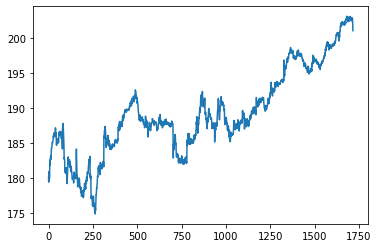

In [231]:
stock1.Close.plot()

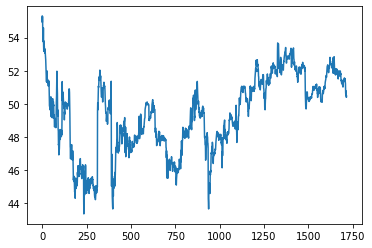

In [232]:
stock2.Close.plot()

### Checking for stationarity over spreads

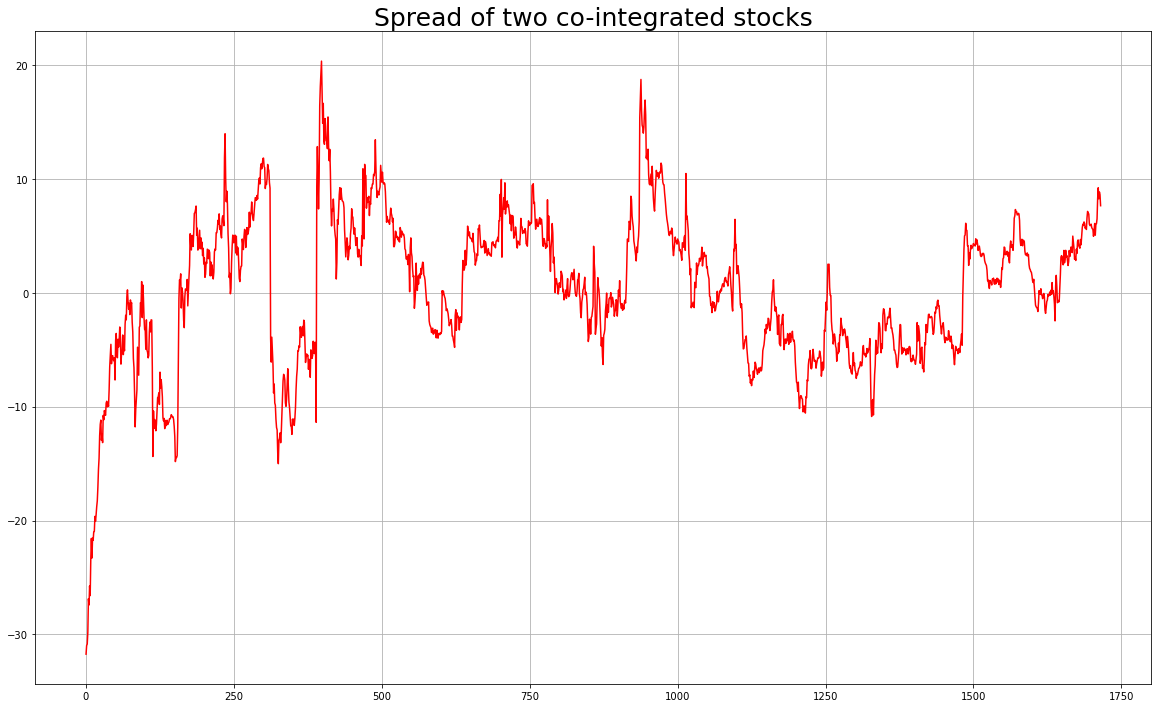

In [233]:
fg = plt.figure(figsize=(20,12))
spread.plot(color='r')
plt.grid()
plt.title("Spread of two co-integrated stocks",size=25)
plt.show()
fg.savefig("haha.png")

In [234]:
import matplotlib.pyplot as plt

The mean of the spread is : 0.21564519689464232


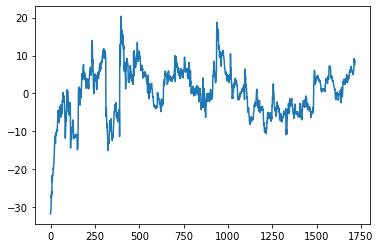

In [235]:
print("The mean of the spread is :",spread.mean())
plt.plot(spread)
plt.show()

#### ADFULLER TEST

In [236]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(spread)

In [237]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.503918
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## DQN Structure

In [238]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.input = nn.Linear(14,50)
        self.dense1 = nn.Linear(50,50)
        self.out = nn.Linear(50, 3)
    ## Forward propagation
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.out(x)

        return x
    ## Train model
    def train(self,X,Y):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.02)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self.forward(inputs)
            loss = criterion(out, labels)
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

## Reinforcement Learning Agent

In [239]:
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size,stock1,stock2):
        self.stock1 = stock1
        self.stock2 = stock2
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3 
        self.batch_size = batch_size
        self.memory = deque(maxlen = 10000000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.8
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.model = DQN()
        
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        current_mean = sum(self.trend[:t+1])/len(self.trend[:t+1])
        
        
        daily_returns = self.trend[t] - self.trend[t-1] if t >= 1 else 0.0
        spread_mean_30 = sum(self.trend[t-29:t+1]) / 30 if t>=30 else sum(self.trend[:t+1])/(t+1)
        mean_over_30 = current_mean/spread_mean_30
        spread_mean_20 = sum(self.trend[t-19:t+1]) / 20 if t>=20 else sum(self.trend[:t+1])/(t+1)
        mean_over_20 = current_mean/spread_mean_20
        spread_mean_15 = sum(self.trend[t-14:t+1]) / 15 if t>=15 else sum(self.trend[:t+1]) /(t+1)
        mean_over_15 = current_mean / spread_mean_15
        spread_mean_10 = sum(self.trend[t-9:t+1]) / 10 if t>=10 else sum(self.trend[:t+1]) /(t+1)
        mean_over_10 = current_mean/spread_mean_10
        spread_mean_7 = sum(self.trend[t-6:t+1]) / 7 if t>=7 else sum(self.trend[:t+1]) /(t+1)
        mean_over_7 = current_mean/spread_mean_7
        spread_mean_5 = sum(self.trend[t-4:t+1]) / 5 if t>=5 else sum(self.trend[:t+1]) /(t+1)
        mean_over_5 = current_mean/spread_mean_5
        
        state = [self.trend[t],daily_returns,
                 spread_mean_30,mean_over_30,
                 spread_mean_20,mean_over_20,
                 spread_mean_15,mean_over_15,
                 spread_mean_10,mean_over_10,
                 spread_mean_7,mean_over_7,
                 spread_mean_5,mean_over_5]
        
        return np.array([state])
    
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory1 = [self.stock1[0]]
        inventory2 = [self.stock2[0]]
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= abs(self.trend[t]) and len(inventory2)>0:
                bought_price = inventory2.pop(0)
                inventory1.append(self.stock1[t])
                initial_money = initial_money - self.stock1[t] + self.stock2[t]
                states_buy.append(t)
                print('day %d: buy 1 sell 2 at difference %f, total balance %f'% (t,  self.stock2[t] - self.stock1[t], initial_money))
                
            elif action == 2 and starting_money >= abs(self.trend[t]) and len(inventory1)>0:
                bought_price = inventory1.pop(0)
                inventory2.append(self.stock2[t])
                initial_money = initial_money - self.stock2[t] + self.stock1[t]
                states_sell.append(t)
                print('day %d: buy 2 sell 1 at difference %f, total balance %f'% (t, self.stock1[t] - self.stock2[t] , initial_money))
                
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def replay(self,batch_size):
        ## Add randomization for the data taken for training
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        
        for i in range(iterations):
            number_of_actions = 0
            total_profit = 0
            inventory1 = [self.stock1[0]]
            inventory2 = [self.stock2[0]]
            state = self.get_state(0)
            starting_money = initial_money
            money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                ## Check if the action is 1 and if I have enough money to execute the action
                if action == 1 and starting_money >= abs(self.stock1[t]-self.stock2[t]) and len(inventory2)>0:
                    number_of_actions +=1
                    bought_price = inventory2.pop(0)
                    inventory1.append(self.stock1[t])
                    starting_money = starting_money - self.stock1[t] + self.stock2[t]
                ## Check if the action is 2 and if I have enough money to execute the action
                elif action == 2 and starting_money >= abs(self.stock1[t]-self.stock2[t]) and len(inventory1)>0:
                    number_of_actions +=1
                    bought_price = inventory1.pop(0)
                    inventory2.append(self.stock2[t])
                    starting_money = starting_money - self.stock2[t] + self.stock1[t]

                ## Calculate the return on investment after the action 

                invest = ((starting_money - initial_money) / initial_money)*100
               
                ## Add the action, and its resultls to the memory for training
                
                self.memory.append((state, action, invest, 
                                    next_state, invest<0))
                
                state = next_state
                money = starting_money
            
            batch_size = min(self.batch_size, len(self.memory))
            random.shuffle(self.memory)
            cost = self.replay(batch_size)
            if len(self.memory) == 10000:
                self.memory.clear()
            
                
            ## MEMORY NEEDS TO BE EMPTIED
            total_profit = starting_money-initial_money
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f, The number of taken actions: %d'%(i + 1, total_profit, cost,
                                                                                  starting_money,number_of_actions))               

In [240]:
## Action 1: Buy first Sell second
## Action 2: Buy second Sell first
## Difference is first-second

In [241]:
initial_money = 10000
window_size = 14
skip = 1
batch_size = 40
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = spread[:1400], 
              skip = skip, 
              batch_size = batch_size,
             stock1 = stock1.Close.tolist()[:1400],
             stock2 = stock2.Close.tolist()[:1400])

In [242]:
agent.train(iterations = 300, checkpoint = 20, initial_money = initial_money)

epoch: 20, total rewards: 130.176331.3, cost: 45.084756, total money: 10130.176331, The number of taken actions: 569
epoch: 40, total rewards: 129.315804.3, cost: 69.734096, total money: 10129.315804, The number of taken actions: 515
epoch: 60, total rewards: -15.671017.3, cost: 224.166326, total money: 9984.328983, The number of taken actions: 344
epoch: 80, total rewards: -143.303425.3, cost: 151.741746, total money: 9856.696575, The number of taken actions: 351
epoch: 100, total rewards: 127.713490.3, cost: 245.037101, total money: 10127.713490, The number of taken actions: 273
epoch: 120, total rewards: 126.058167.3, cost: 214.915223, total money: 10126.058167, The number of taken actions: 217
epoch: 140, total rewards: 120.717590.3, cost: 246.674066, total money: 10120.717590, The number of taken actions: 199
epoch: 160, total rewards: 123.085220.3, cost: 502.751360, total money: 10123.085220, The number of taken actions: 157
epoch: 180, total rewards: 125.894909.3, cost: 327.2749

Giving the agent the right data for testing

In [243]:
agent.stock2 = stock2.Close.tolist()[1400:]
agent.stock1 = stock1.Close.tolist()[1400:] 
agent.trend = spread.values.tolist()[1400:]

In [244]:
#Running the test
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = 10000)

day 0: buy 2 sell 1 at difference 144.694996, total balance 10144.694996
day 107: buy 1 sell 2 at difference -146.505001, total balance 9998.189995
day 108: buy 2 sell 1 at difference 146.450001, total balance 10144.639996
day 129: buy 1 sell 2 at difference -144.969997, total balance 9999.669998
day 130: buy 2 sell 1 at difference 144.919994, total balance 10144.589993
day 173: buy 1 sell 2 at difference -149.254997, total balance 9995.334995
day 174: buy 2 sell 1 at difference 149.090000, total balance 10144.424995
day 237: buy 1 sell 2 at difference -147.230003, total balance 9997.194992
day 238: buy 2 sell 1 at difference 146.970001, total balance 10144.164993
day 294: buy 1 sell 2 at difference -151.789993, total balance 9992.375000
day 295: buy 2 sell 1 at difference 151.390003, total balance 10143.765003


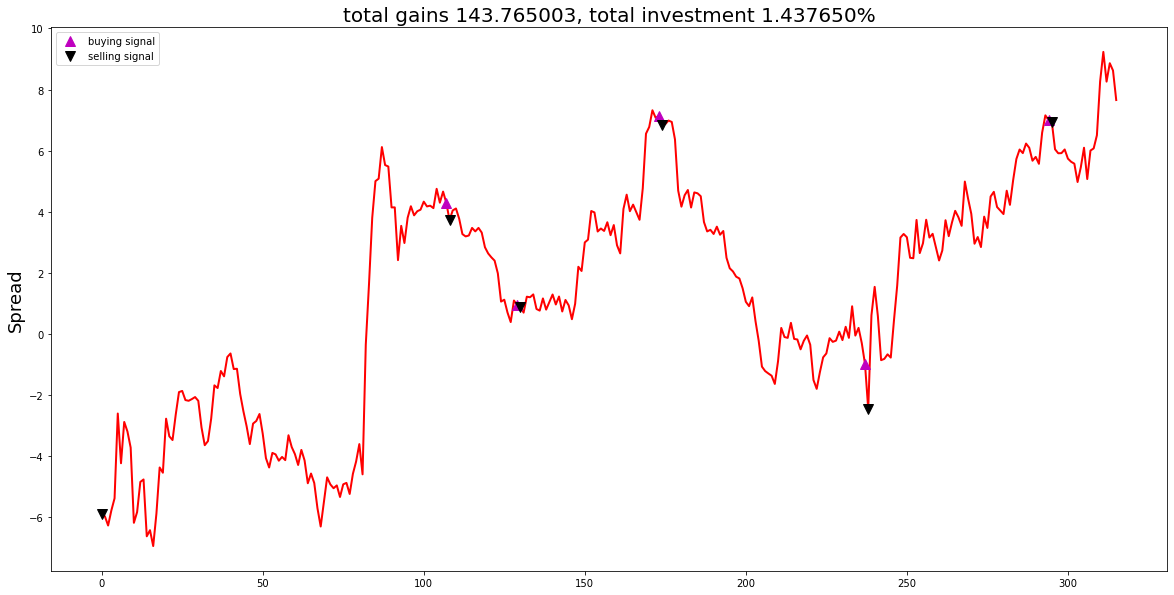

In [245]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
plt.plot(agent.trend, color='r', lw=2.)
plt.plot(agent.trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(agent.trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest),size= 20)
plt.ylabel("Spread",size = 18)
plt.legend(), '^'
plt.show()
fig.savefig("Test_Actions_Over_Spread.png",dpi = 500)

In [246]:
states_no = 316 - len(states_buy)-len(states_sell)

In [247]:
print(states_no)

305


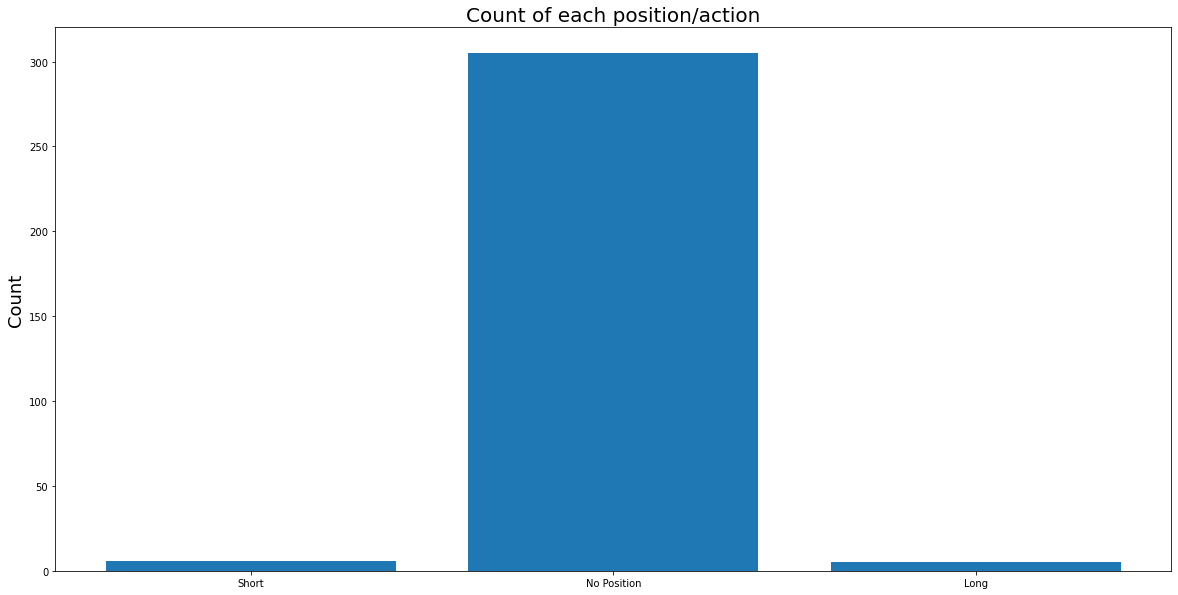

In [248]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
positions = ['Short','No Position','Long']
count_position = [len(states_sell),states_no,len(states_buy)]

plt.bar(positions, count_position)
plt.title('Count of each position/action',size=20)
plt.ylabel('Count',size=18)
plt.show()
fig.savefig("Action_count.png",dpi=500)